- title: tutorial: Meta-Analysis: Python Pipeline
- date: 2020-05-02 12:00
- category: tutorial
- tags: neuroscience, python, meta-analysis
- slug: meta_analysis_python
- authors: Julien Hernandez Lallement
- summary: Brief description of meta-analytical proceedings
- illustration: 2020_04_meta_analysis_header.jpg

## Meta-Analysis: Python Pipeline

## Table of Content

### [Dataset](#dataset)

### [Data Transformation](#data_transformation)

In a previous post, I have presented the theoretical background of running a meta-analysis.<br><br>
Here, I will using some of these equations to analyse a dataset collected in the lab.

<a id="dataset"></a>
### **Dataset:** <br>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

On our project, we were interested to find which brain regions showed activation when individuals witnessed emotions in others (so-called emotional contagion, i.e.,  first building block of empathy, see [here](https://www.cambridge.org/core/journals/behavioral-and-brain-sciences/article/empathy-its-ultimate-and-proximate-bases/953E0D092176FEE351ED81E933FE646D). I did this work together with Dr. Maria Carrillo, check out some of her work [here](https://www.sciencedirect.com/science/article/pii/S0960982219303227).<br>
The data was collected manually in most of the cases, because researchers are not always good at reporting all the necessary statistics to extract effect sizes. That mean that we had to go to the papers, with a ruler and a pencil, and measure the actual distribution's means and standard deviations.  Fun at first, very fast very annoying... There are some good softwares that help you collect the data from pdf formats though, like [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/).

Within a year of regular meetings and data compilation, we managed to screen and extract brain activation data (among other data, not discussed here) in approximately 150 research papers (of a total of 3000 papers screened).

In [2]:
# Set path
# Ubuntu
work_dir = "/home/julien/Documents/Projects/datasets/meta_analysis"
# Windows
#work_dir = "C:\\Users\hernandez\Dropbox (Personal)\Python\meta_analysis"
os.chdir(work_dir)
# Verify the path
cwd = os.getcwd() 
# Print the current directory 
print("Current working directory is:", cwd) 

Current working directory is: /home/julien/Documents/Projects/datasets/meta_analysis


In [3]:
files = os.listdir(cwd)
df = pd.read_excel(io = files[files.index("Effect_size_pooled_c-fos_v2.xlsx")], 
                   sheet_name ='c-fos_only',
                   header     = 1,
                   index_col  = None)

# lower case to avoid later conflicts
df.columns = [c.lower() for c in df.columns]
# display columns
df.shape

(144, 66)

What we have is a series of data features for each independent experimental group that we screened in the literature. <br>
I will hard code the specie from which the data was collected, which will be our main spliting variable in this analysis. Indeed, we ended up with a relatively small dataset, which is not enough to look at how the other variables might have influenced brain activity.

In [4]:
# Create dictionnary of the species encoded
specie_dict ={0 : 'rat', 1 : 'mouse'}
# Map the binary coding onto the dictionnary
df['specie_str'] = df['specie '].map(specie_dict)

Then, I select the data of interest:

In [5]:
# Select data of interest
DOI = df[['study id','specie ', 
          'specie_str', 
          'structure / tissue', 
          'structure_renamed',              
          'standardized es',    
          'standardized es se', 
          'weight factor', 
          'n']]

In [9]:
DOI.head(10)

,study id,specie,specie_str,structure / tissue,structure_renamed,standardized es,standardized es se,weight factor,n
0,2,0,rat,ACC,ACC,0.927872,0.235702,18,21
1,2,0,rat,LA,Amygd_LA,0.927872,0.235702,18,21
2,2,0,rat,HPC,HPC,0.300000,0.235702,18,21
3,2,0,rat,ACC,ACC,0.678397,0.258199,15,18
4,2,0,rat,HPC,HPC,0.089124,0.408248,6,9
5,77,0,rat,LA,Amygd_LA,0.768121,0.447214,5,8
6,77,0,rat,CeM,Amygd_CeM,0.308701,0.447214,5,8
7,77,0,rat,CeL,Amygd_CeL,0.344366,0.447214,5,8
8,77,0,rat,PrL,PrL,0.455106,0.447214,5,8
9,77,0,rat,IL,IL,-0.372895,0.447214,5,8


Below, a description of the columns:<br>
**study_id**: single identifier of the study from which the data was extracted<br>
**specie: binary** informing on the specie from which the brain activity was recorded<br>
**specie_str**: binary string information informing on the specie from which the brain activity was recorded<br>
**structure / tissue**: Brain structure from which the activity was recorded<br>
**structure_renamed**: Renamed structure<br>
**standardized es**: standardized effect size<br>
**standardized es se**: standard error of the mean attached to the effect size<br>
**weight factor**: weight facto<br>
**n**: number of animals from which the data was collected<br>

Now we are interested in computing the effect size, per specie and brain structure. <br>
Let's look at how many data points we would have per category

In [11]:
(DOI
.groupby(['specie_str', 'structure_renamed'])
.count()
.sort_values('n', ascending=False)
)

study id  specie   structure / tissue  \
specie_str structure_renamed                                          
rat        Amygd_LA                 14       14                  14   
           Amygd_CeA                 8        8                   8   
           PAG                       8        8                   8   
           IL                        7        7                   7   
           PVN                       7        7                   7   
           Amygd_BLA                 6        6                   6   
           Amygd_BA                  6        6                   6   
           PrL                       6        6                   6   
           Hypothalamus              6        6                   6   
           Amygd_MeA                 5        5                   5   
           Amygd_CoA                 5        5                   5   
           Amygd_CeM                 5        5                   5   
           ACC                       5        5                   5   
           NaCC                      4        4                   4   
mouse      Amygd_BLA                 4        4                   4   
rat        INS                       3        3                   3   
mouse      HPC                       3        3                   3   
           Amygd_LA                  3        3                   3   
rat        Amygd_CeL                 3        3                   3   
           BNST                      3        3                   3   
           BMA                       3        3                   3   
           PFC                       3        3                   3   
           HPC                       2        2                   2   
           Septum                    2        2                   2   
mouse      Amygd_CeL                 2        2                   2   
           Amygd_CeM                 2        2                   2   
           Amygd_CoA                 2        2                   2   
           Amygd_MeA                 2        2                   2   
           IL                        2        2                   2   
           PrL                       2        2                   2   
           Septum                    1        1                   1   
rat        LPO                       1        1                   1   
mouse      Amygd_CeA                 1        1                   1   
           Hypothalamus              1        1                   1   
           BNST                      1        1                   1   
           INS                       1        1                   1   
           NaCC                      1        1                   1   
           PAG                       1        1                   1   
           PFC                       1        1                   1   
           PVN                       1        1                   1   
           ACC                       1        1                   1   

                              standardized es  standardized es se  \
specie_str structure_renamed                                        
rat        Amygd_LA                        14                  14   
           Amygd_CeA                        8                   8   
           PAG                              8                   8   
           IL                               7                   7   
           PVN                              7                   7   
           Amygd_BLA                        6                   6   
           Amygd_BA                         6                   6   
           PrL                              6                   6   
           Hypothalamus                     6                   6   
           Amygd_MeA                        5                   5   
           Amygd_CoA                        5                   5   
           Amygd_CeM                        5                   5   
          

That's quite low for many structures (n of 1 will be hard to make meta-analytics...), but we can work with some of these structures that have more 2 or 3 effect sizes. <br>
Seems though like there are much more effect sizes for rats than mice:

In [6]:
(DOI
.groupby(['specie_str'])
.count()['study id']
)

specie_str
mouse     32
rat      112
Name: study id, dtype: int64

Yup. That is something typical in research literature though. Some models are widely used, leaving some areas of the knowledge unpopuplated. But still, we can move on and see what we get.

<a id="data_transformation"></a>
### **Data Transformation:** <br>

As explained in the methods, there are different steps needed in a meta-analytic process.<br><br>Below, I implemented these steps in python:

In [15]:
# This function will add a few computations to the dataset.
# Computations are self explanatory, and equations are in methods
def compute_meta_data(dataf):
    return (dataf
            .assign(vi_SE2           = lambda d:  1/d['weight factor']) # Equation 15
            .assign(standardized_ESU = lambda d:  d['standardized es'] 
                    * (1-(3/(4*(d['n'])-9)))) # Equation 9
            .assign(wES              = lambda d:  d['standardized es'] 
                    * d['weight factor'])
            .assign(wES2             = lambda d:  d['weight factor']   
                    * d['standardized es'] * d['standardized es']) 
            .assign(w2               = lambda d:  d['weight factor']   
                    * d['weight factor']))


In [16]:
# This function will compute, for each specie&structure, the random effect parameters
def compute_random_effects(dataf):
    return (dataf
            .groupby(['specie_str','structure_renamed'])
            .apply(lambda d: pd.Series({  
            "sum_wi":          d['weight factor'].sum(),
            "sum_wi2":         d['w2'].sum(),
            "k":               d['w2'].count(), #num studies
            "wxES":            d['wES'].sum(),
            "wxES2":           d['wES2'].sum()     
            })))

In [17]:
# Compute the Q and v0 parameters (see methods)
def compute_random_variance(dataf):
    return (dataf
            .assign(Q  = lambda d:  abs(d['wxES2']-(d['wxES']**2/d['sum_wi']))) 
            # For struture with only 1 effect size, the denominator of v0 will 
            # automatically be equal to 0. hence v0 will not be computed.
            .assign(v0 = lambda d:  (d['Q']-(d['k']-1))/(d['sum_wi']-
                                                        (d['sum_wi2']/d['sum_wi'])))
           )

In [18]:
# Turn v0 to 0 if negative (missing reference!)
def zero_if_negative(dataf):
        num = dataf['v0']
        num[num < 0] = 0
        dataf['v0'] = num
        return dataf

In [19]:
# Compute corrected parameters (see methods)
def apply_corrections(dataf):
    return (dataf
            .assign(v0_plus_vi       = lambda d:  d['vi_SE2']+d['v0'])  
            .assign(wi_corr          = lambda d:  1/d['v0_plus_vi'])  
            .assign(wxES_corr        = lambda d:  d['wi_corr']*d['standardized_ESU'])  
            .assign(wxESsq_corr      = lambda d:  d['wi_corr']*(d['standardized_ESU']**2))
            .assign(SE_corr          = lambda d:  (1/(d['wi_corr'])**0.5))  
            .fillna(0) # NaN are replaced by 0
            .replace(np.inf, 0)
)

In [20]:
def calculate_constants(dataf):
    return (dataf
            .groupby(['specie_str', 'structure_renamed'])
            .apply(lambda d: pd.Series({  
                        "sum_wxES_corr":        d['wxES_corr'].sum(),
                        "sum_wxESsq_corr":      d['wxESsq_corr'].sum(), #num studies                  
                        "sum_wi_corr":          abs(d['wi_corr']).sum(), 
             })) 
             .fillna(0) # NaN are replaced by 0
             .replace(np.inf, 0)
           )

The function below computes the $I^2$ value, ie, percent of variation due to heterogeneity rather than chance.
By convention, Q = 0 if Q < k-1, so that the precision of a random effects summary estimate will not exceed the precision of a fixed effect summary estimate, see [Higgins & Thompson 2002](https://onlinelibrary.wiley.com/doi/10.1002/sim.1186)

In [21]:
def I2(Q,dfg):
#     if pd.isnull((Q < dfg)):
#         I2 = 0
#         return I2
#     else:
        I2=((Q-dfg)/Q)*100
        return I2

In [22]:
def calculate_mean_se(dataf):
    return (dataf
            .assign(ES_mean       = lambda d: d['sum_wxES_corr']/d['sum_wi_corr']) 
            .assign(SE_mean       = lambda d: (1/d['sum_wi_corr'])**0.5)
            .assign(z             = lambda d: d['ES_mean']/d['SE_mean'])
            .assign(high_CI       = lambda d: d['ES_mean']+(1.96*d['SE_mean']))
            .assign(low_CI        = lambda d: d['ES_mean']-(1.96*d['SE_mean']))                                              
           # .assign(k_val         = lambda d: d['w2'].count())#num studies  
            .assign(I_val         = lambda d: I2(d['Q'],d['k']-1))
           )

In [23]:
def calculate_number_es(dataf):
    return (dataf
            .groupby(['specie_str', 'structure_renamed'])
            .apply(lambda d: pd.Series({  
                        "k_val": d['w2'].count(),
             })) 
           )

In [24]:
# Compute & add meta variables to dataset
cfos_df = DOI.pipe(compute_meta_data)
# Compute & add random effect parameters
rand_df = (cfos_df
.pipe(compute_random_effects)
.pipe(compute_random_variance)
.pipe(zero_if_negative)
)
# Merge datasets
cfos_ana = pd.merge(cfos_df, rand_df, on=['structure_renamed','specie_str'])
cfos_ana = apply_corrections(cfos_ana)
# Compute constants for each structure
constants = calculate_constants(cfos_ana)
cfos_ana = pd.merge(cfos_ana, constants, on=['structure_renamed','specie_str'])
# Compute mean & se for each structure
cfos_ana = (cfos_ana
.pipe(calculate_mean_se))
# Calculate number of ES per structure
nES = (cfos_ana
.pipe(calculate_number_es)           
)
cfos_ana = pd.merge(cfos_ana, nES, on=['structure_renamed','specie_str'])

# Sample dataframe
cfos_ana.head(3)


,study id,specie,specie_str,structure / tissue,structure_renamed,standardized es,standardized es se,weight factor,n,vi_SE2,...,sum_wxES_corr,sum_wxESsq_corr,sum_wi_corr,ES_mean,SE_mean,z,high_CI,low_CI,I_val,k_val
0,2,0,rat,ACC,ACC,0.927872,0.235702,18,21,0.055556,...,18.885442,15.12257,32.517006,0.580787,0.175366,3.311859,0.924503,0.23707,40.641371,5
1,2,0,rat,ACC,ACC,0.678397,0.258199,15,18,0.066667,...,18.885442,15.12257,32.517006,0.580787,0.175366,3.311859,0.924503,0.23707,40.641371,5
2,207,0,rat,ACC,ACC,0.744927,0.242536,17,20,0.058824,...,18.885442,15.12257,32.517006,0.580787,0.175366,3.311859,0.924503,0.23707,40.641371,5


In [26]:
# By convention, Q = 0 if Q < k-1, so that the precision of a random effects summary estimate will not exceed the precision of a fixed effect summary estimate
cfos_ana.loc[cfos_ana['Q'] < (cfos_ana['k_val']-1), 'I_val'] = 0 

In [31]:
# Prepare data for plotting
to_plot = (cfos_ana
#.groupby(['specie_str'])
.drop_duplicates(subset =["specie_str", "structure_renamed"], inplace = False)
.dropna()
#.groupby(['specie_str', 'structure_renamed'])
#.head(20)
)
to_plot = to_plot[['specie_str', 
                   'structure_renamed',
                   'ES_mean', 
                   'low_CI',
                   'high_CI', 
                   'z', 
                   'I_val', 
                   'k_val']]
# Visualize higher effect sizes per species
(to_plot
.groupby(["specie_str"])
.apply(lambda x: x.sort_values(["ES_mean"], ascending = False))
.reset_index(drop=True)
)

,specie_str,structure_renamed,ES_mean,low_CI,high_CI,z,I_val,k_val
0,mouse,Amygd_BLA,0.305320,-0.012634,0.623274,1.882120,0.000000,4
1,mouse,IL,0.250577,-0.273255,0.774409,0.937572,0.000000,2
2,mouse,PrL,0.227964,-0.570073,1.026001,0.559887,56.913815,2
3,mouse,Amygd_CeL,0.111359,-0.412473,0.635191,0.416668,0.000000,2
4,mouse,Amygd_CeM,0.045174,-0.478658,0.569006,0.169027,0.000000,2
5,mouse,Amygd_MeA,0.025072,-0.498760,0.548904,0.093812,0.000000,2
6,mouse,Amygd_CoA,0.004438,-0.569050,0.577927,0.015169,16.567528,2
7,mouse,HPC,-0.131467,-0.559174,0.296240,-0.602458,0.000000,3
8,mouse,Amygd_LA,-0.177468,-0.605175,0.250240,-0.813258,0.000000,3
9,rat,ACC,0.580787,0.237070,0.924503,3.311859,40.641371,5


In [32]:
#import plotnine as p9
import plotnine as p9
from plotnine import ggplot, geom_point, aes, theme, element_text, save_as_pdf_pages
p9.options.figure_size = (6.4, 4.8)

/home/julien/anaconda3/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/julien/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/home/julien/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/home/julien/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 11 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/julien/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Us

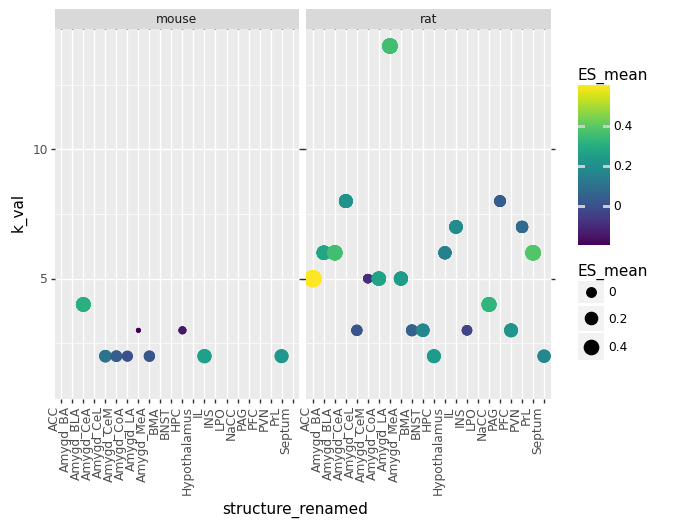

<ggplot: (8754481162689)>

In [39]:
# Plot the effect sizes for each structure, separately for each specie
(p9.ggplot() +
p9.geom_point(data = cfos_ana, 
              mapping = p9.aes('structure_renamed', 
                               'k_val', 
                               color='ES_mean', 
                               size='ES_mean'
                              )
             ) +
p9.facet_wrap("specie_str") + 
theme(axis_text_x=element_text(rotation=90, hjust=1))
)

Thats's about it! In this notebook, I tried to summarize some equations and practices one might use when running meta-analysis. This work was my own doing, and I do not ensure that all mathemathical implementations are 100% correct, although I reference the papers from which the equations were taken from whenever I can. <br><br>

I hope you enjoyed it, and do not hesitate in contacting me if you have questions, commentaries, or spot an issue or some room for improvement!

The functions described in this post can be found in the following repo:
https://github.com/juls-dotcom/meta_analysis

Cheers!